<a href="https://colab.research.google.com/github/msbeigi/GaussianMixtureModel-EM-Clustering/blob/main/gmm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal


**Task 2)**

In [2]:

data = np.loadtxt('/content/drive/MyDrive/Uni/Aston/Coursework/Probabilistic Modeling/EpidemicCases.txt')


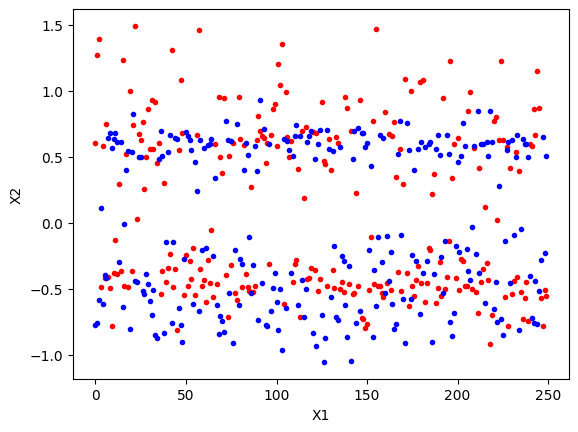

In [3]:
# Plot data points
plt.plot(data[:, 0:1], 'r.')
plt.plot(data[:, 1:2], 'b.')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [18]:
def plot_gaussian(mu, cov, color):
    """
      Plot a Gaussian distribution with specified mean, covariance, and color.

      Parameters:
      - mu (numpy array): Mean of the Gaussian distribution.
      - cov (numpy array): Covariance matrix of the Gaussian distribution.
      - color (str): Color for the plot.

      Returns:
      - matplotlib Ellipse: Ellipse representing the Gaussian distribution.
      """
    eigenvalues, eig_vector = np.linalg.eig(cov)
    eigenvalues = np.sqrt(eigenvalues)
    ell = Ellipse(xy=mu, width=eigenvalues[0]*2, height=eigenvalues[1]*2,
                  angle=np.rad2deg(np.arccos(eig_vector[0, 0])), color=color)
    ell.set_facecolor('none')
    return ell

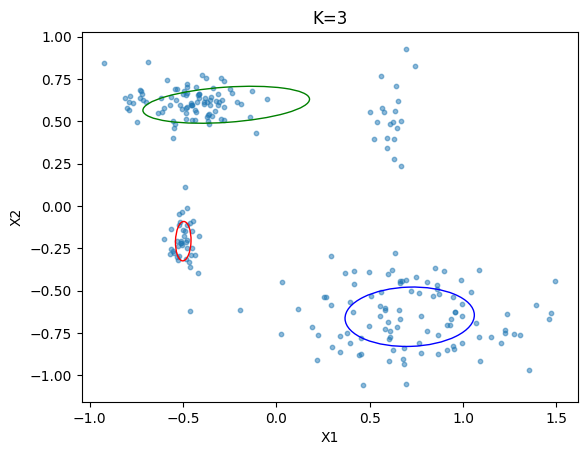

In [25]:

def gmm_e_step(data, means, covariances, weights):
    """
      Perform the Expectation (E) step of the EM algorithm for GMM.

      Parameters:
      - X (numpy array): Data points.
      - means (list): List of means for each Gaussian component.
      - devi (list): List of covariance matrices for each Gaussian component.
      - weights (numpy array): Weights for each Gaussian component.

      Returns:
      - tuple: Tuple containing posterior probabilities matrix and labels.
    """
    N, D = data.shape
    K = len(weights)
    posteriors = np.zeros((N, K))
    for k in range(K):
        posteriors[:, k] = weights[k] * multivariate_normal.pdf(data, means[k], covariances[k])
    posteriors /= posteriors.sum(axis=1, keepdims=True)
    labels = np.argmax(posteriors, axis=1)
    return posteriors, labels

def gmm_m_step(data, posteriors):
    """
      Perform the Maximization (M) step of the EM algorithm for GMM.

      Parameters:
      - X (numpy array): Data points.
      - posteriors (numpy array): Matrix of posterior probabilities.

      Returns:
      - tuple: Tuple containing updated weight, mean, sigma, and centered points.
    """
    N, D = data.shape
    K = posteriors.shape[1]
    weights = posteriors.mean(axis=0)
    means = np.zeros((K, D))
    covariances = np.zeros((K, D, D))
    for k in range(K):
        Nk = posteriors[:, k].sum()
        means[k] = np.sum(data * posteriors[:, k, None], axis=0) / Nk
        X_centered = data - means[k]
        covariances[k] = (X_centered.T @ (X_centered * posteriors[:, k, None])) / Nk
    return weights, means, covariances

def gmm_em(data, K, n_iter=100):
    """
    Perform the Expectation-Maximization algorithm for Gaussian Mixture Model.

    Parameters:
    - X (numpy array): Data points.
    - K (int): Number of Gaussian components.
    - n_iter (int): Number of iterations.

    Returns:
    - tuple: Tuple containing weight, mean, sigma, posterior matrix, labels, and likelihoods.
    """
    N, D = data.shape
    weights = np.ones(K) / K
    means = data[np.random.choice(N, K, replace=False)]
    covariances = np.array([np.eye(D)] * K)
    likelihoods = []
    for i in range(n_iter):
        posteriors, labels = gmm_e_step(data, means, covariances, weights)
        weights, means, covariances = gmm_m_step(data, posteriors)
        log_likelihood = np.sum(np.log(np.sum(posteriors, axis=1)))
        likelihoods.append(log_likelihood)
    return weights, means, covariances, posteriors, labels, likelihoods

K = 3
weights, means, covariances, posteriors, labels, likelihoods = gmm_em(data, K, n_iter=100)

# Create scatter plot of the data points
fig, ax = plt.subplots()
ax.scatter(data[:, 0], data[:, 1], s=10, alpha=0.5)

# Plot the Gaussian components
colors = ['red', 'blue', 'green']
for i in range(K):
    ell = plot_gaussian(means[i], covariances[i], colors[i])
    ax.add_artist(ell)

ax.set_title('K=3')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
plt.show()

**b)**

In [6]:

def gmm_e_step(X, means, devi, weights):
    N, D = X.shape
    K = len(weights)
    posteriors = np.zeros((N, K))
    for k in range(K):
        posteriors[:, k] = weights[k] * multivariate_normal.pdf(X, means[k], devi[k])  # scaled probability distribution each point based on the initiated mean and sigma(deviation)
    posteriors /= posteriors.sum(axis=1, keepdims=True)
    labels = np.argmax(posteriors, axis=1)   # get the label with the highest responsibility for each data point
    return posteriors, labels

def gmm_m_step(X, posteriors ):
    X_centered_points=[]
    N, D = X.shape
    K = posteriors .shape[1]
    weight = posteriors .mean(axis=0)       # compute the mean of matrix of posterior probabilities (pdf) across the rows
    mu = np.zeros((K, D))
    sigma = np.zeros((K, D, D))
    for k in range(K):
        Nk = posteriors [:, k].sum()        # (marginal probability)value representing the total posterior probability assigned to the k-th Gaussian component
        mu[k] = np.sum(X * posteriors [:, k, None], axis=0) / Nk    # update mean with the sum of the likelihood to belong to the k-th Gaussian component
        X_centered = X - mu[k]          # calculate the centered data
        sigma[k] = (X_centered.T @ (X_centered * posteriors [:, k, None])) / Nk     # updating the covariance matrix
        X_centered_points.append(X_centered)
    return weight, mu, sigma,X_centered_points

def gmm_em(X, K, n_iter=100):
    N, D = X.shape
    weight = np.ones(K) / K   # same weight initition
    mu = X[np.random.choice(N, K, replace=False)]
    sigma = np.array([np.eye(D)] * K)   # creating K matrices for categorizing the sigma for each group
    likelihoods = []
    for i in range(n_iter):
        postpro_mat, labels = gmm_e_step(X, mu, sigma, weight)
        weight, mu, sigma,_ = gmm_m_step(X, postpro_mat)
        log_likelihood = np.sum(np.log(np.sum(postpro_mat, axis=1)))
        likelihoods.append(log_likelihood)
    return weight, mu, sigma,postpro_mat, labels, likelihoods


In [7]:
K=3
N, D = data.shape
T=np.array([np.eye(D)] * K)
weight = np.ones(K) / K
print(f'weight:{weight} \nsigma{T}')

weight:[0.33333333 0.33333333 0.33333333] 
sigma[[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]


In [8]:
m=data[np.random.choice(N, K, replace=False)]
m

array([[ 0.40903124, -0.62588401],
       [ 0.92908367, -0.70155686],
       [-0.45000002,  0.59607506]])

In [9]:
weight, mu, sigma, post, labels, likely=gmm_em(data, K=3, n_iter=100)

In [10]:
labels

array([1, 1, 1, 0, 1, 0, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 0, 2, 2, 1, 2, 2,
       1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 0, 2, 2, 1, 0,
       2, 2, 1, 1, 1, 0, 2, 2, 2, 2, 1, 2, 2, 1, 2, 0, 2, 0, 2, 2, 2, 0,
       2, 0, 1, 1, 1, 1, 2, 2, 1, 2, 1, 0, 2, 1, 1, 0, 2, 2, 2, 0, 1, 0,
       2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2,
       2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2,
       0, 1, 1, 2, 0, 0, 1, 1, 0, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 0, 2, 1,
       0, 1, 0, 2, 0, 2, 1, 0, 1, 0, 1, 1, 1, 2, 2, 0, 1, 1, 2, 2, 1, 0,
       2, 0, 2, 1, 2, 1, 2, 0, 2, 2, 1, 1, 2, 2, 2, 0, 1, 0, 2, 2, 1, 1,
       1, 0, 2, 0, 2, 2, 2, 0, 1, 1, 0, 2, 0, 2, 1, 2, 2, 1, 2, 2, 2, 2,
       1, 1, 1, 2, 1, 1, 0, 2, 2, 1, 2, 0, 2, 2, 1, 0, 2, 2, 2, 2, 1, 1,
       1, 1, 1, 1, 0, 2, 0, 2])

In [ ]:
weight

array([0.08000013, 0.39937674, 0.52062314])

In [ ]:
sigma

array([[[ 0.00338747,  0.00281684],
        [ 0.00281684,  0.02978197]],

       [[ 0.11512842, -0.00315233],
        [-0.00315233,  0.03089621]],

       [[ 0.02220358,  0.00392961],
        [ 0.00392961,  0.15467875]]])

In [ ]:
mu

array([[-0.49860707, -0.20734344],
       [ 0.71393202, -0.65362253],
       [-0.26850642,  0.59787957]])

In [ ]:
likely

**(b)** plot the resulting mixture model (in the form of Gaussians in this two dimensional space).

In [11]:
X=data

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))


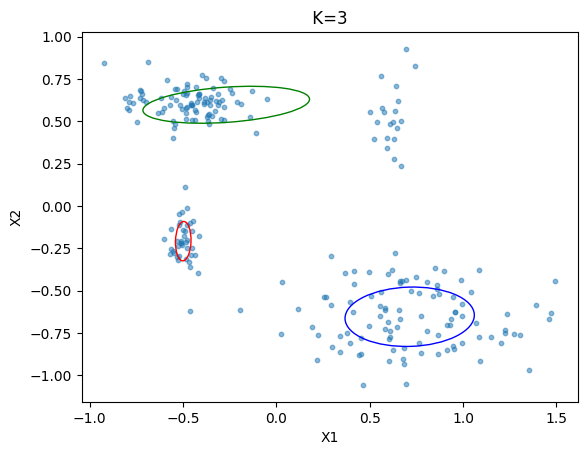

In [12]:
K = 3
# weights, means, covariances = gmm_em(X, K)

# Create scatter plot of the data points
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], s=10, alpha=0.5)

# Plot the Gaussian components
colors = ['red', 'blue', 'green']
for i in range(K):
    ell=plot_gaussian(mu[i], sigma[i], colors[i])
    ax.add_artist(ell)
ax.set_title(' K=3 ')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
plt.show()

K=4

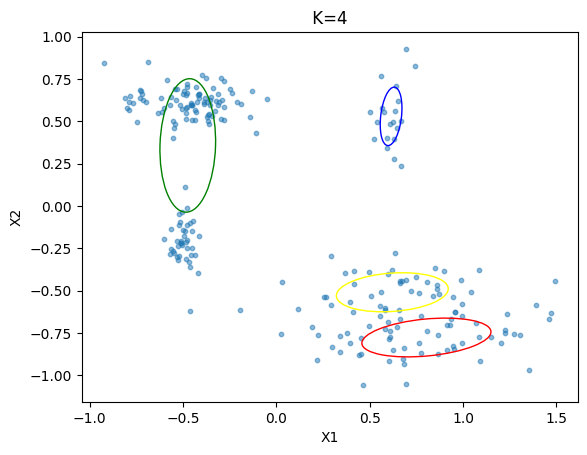

In [14]:
K=4
weight_4, mu_4, sigma_4,gamma_4, labels_4,likely_4=gmm_em(data, K=4, n_iter=100)
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], s=10, alpha=0.5)

# Plot the Gaussian components
colors = ['red', 'blue', 'green','yellow']
for i in range(K):
    ell=plot_gaussian(mu_4[i], sigma_4[i], colors[i])
    ax.add_artist(ell)
ax.set_title(' K=4 ')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
plt.show()

K=5


In the case where k=5 and there are two ellipsoids overlapping in one cluster, it is possible that the algorithm has converged to a suboptimal solution due to initialization or other factors. It may be worth trying different initialization strategies or running the algorithm for more iterations to see if a better solution can be found. Alternatively, it may be necessary to adjust the parameters of the algorithm or the data preprocessing to obtain better results.

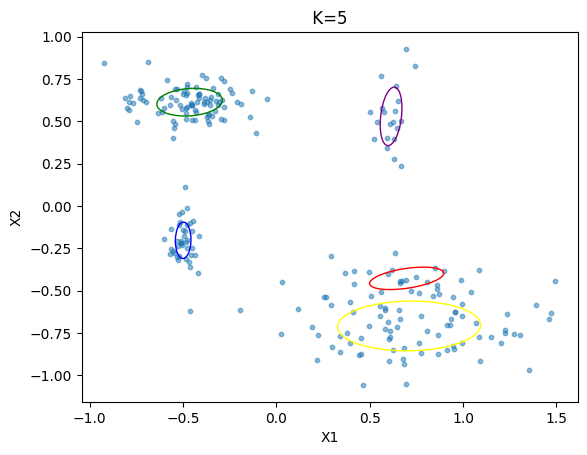


Likelihood5:8.88178419700124e-16

weight5:[0.07806517 0.15682387 0.36000002 0.32511065 0.0800003 ]

sigma5:[[[ 3.93642053e-02 -5.98291688e-03]
  [-5.98291688e-03  4.39135899e-03]]

 [[ 1.74125759e-03 -1.28995041e-04]
  [-1.28995041e-04  1.15359299e-02]]

 [[ 3.07897985e-02 -1.98823031e-03]
  [-1.98823031e-03  6.66885811e-03]]

 [[ 1.46597820e-01 -2.06810273e-03]
  [-2.06810273e-03  2.15922383e-02]]

 [[ 3.38745687e-03  2.81678504e-03]
  [ 2.81678504e-03  2.97828309e-02]]]

gamma5:[[7.95776403e-009 3.54469518e-157 6.55237287e-066 9.99999992e-001
  7.26448821e-014]
 [1.07045394e-005 0.00000000e+000 1.65041146e-073 9.99989295e-001
  1.02696377e-054]
 [1.28815541e-002 0.00000000e+000 5.57865459e-062 9.87118446e-001
  7.94650277e-063]
 ...
 [1.37175025e-057 4.78736247e-023 1.00000000e+000 7.23546169e-022
  3.15142033e-139]
 [1.88013525e-009 9.99992049e-001 1.38675665e-024 7.94957318e-006
  2.62777683e-082]
 [1.18091178e-043 8.90056206e-010 9.99999999e-001 1.32270597e-017
  1.24586057e-095]

In [15]:
k=5
weight_5, mu_5, sigma_5,gamma_5, labels_5,likely_5=gmm_em(data, K=k, n_iter=100)
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], s=10, alpha=0.5)

# Plot the Gaussian components
colors = ['red', 'blue', 'green','yellow','purple']
for i in range(k):
    ell=plot_gaussian(mu_5[i], sigma_5[i], colors[i])
    ax.add_artist(ell)
ax.set_title(' K=5 ')
ax.set_xlabel('X1')
ax.set_ylabel('X2')

plt.show()

print (f'\nLikelihood5:{max(likely_5)}')
print (f'\nweight5:{weight_5}')
print (f'\nsigma5:{sigma_5}')
print (f'\ngamma5:{gamma_5}')


**c)**

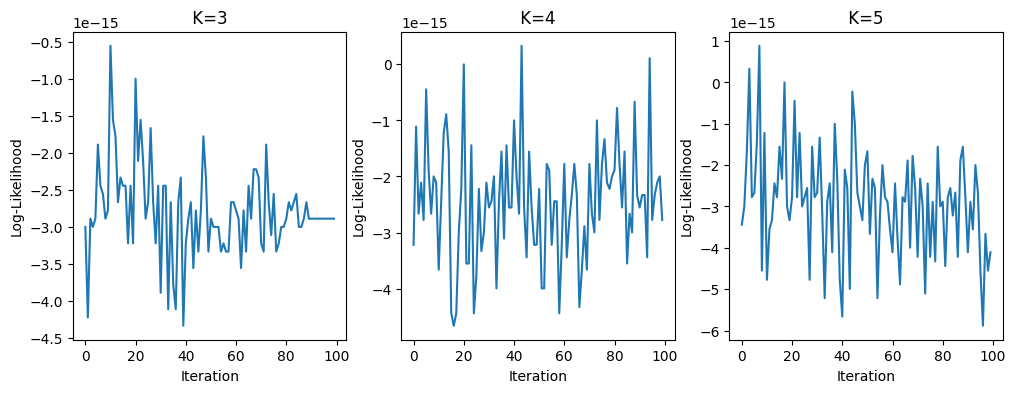

In [16]:
# likelihood

fig,ax=plt.subplots(1,3,figsize=(12,4))
ax[0].plot(likely)
ax[0].set_title(' K=3 ')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Log-Likelihood')

ax[1].plot(likely_4)
ax[1].set_title(' K=4 ')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Log-Likelihood')

ax[2].plot(likely_5)
ax[2].set_title(' K=5 ')
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Log-Likelihood')

plt.show()

d)

In [ ]:
def calculate_bic(X, weights, means, covariances, log_likelihood):
    N, D = X.shape
    K = len(weights)
    num_params = K * (D + D*(D+1)//2 + 1) - 1  # Number of parameters in the GMM
    bic = -2 *  (np.array(log_likelihood) * 1e6) + num_params * np.log(N)
    return bic


In [ ]:
BIC_3=calculate_bic(X, weight, mu, sigma, likely[-1])
BIC_3

93.8648356087652

In [ ]:
BIC_4=calculate_bic(X, weight_4, mu_4, sigma_4, likely_4[-1])
BIC_4

126.99360111882527

In [ ]:
BIC_5=calculate_bic(X, weight_5, mu_5, sigma_5, likely_5[-1])
BIC_5

160.12236662155786

In [ ]:
weight

array([0.39937674, 0.52062314, 0.08000013])

In [ ]:
weight_4

array([0.4012531 , 0.0800001 , 0.35999986, 0.15874694])

In [ ]:
weight_5

array([0.07999922, 0.11762937, 0.15686979, 0.36000001, 0.2855016 ])